# Universal estimator

Let $f(x|d_1,...,d_n)$ be a function, that for any fixed values of the parameters $d_i$, reduces to a PDF of x; $f$ thus is a family of functions, e.g., *log normal*.

$estimator(f, sample)$ is a function which learns the parameters $d_i$ of $f$ from a single input *sample* ($m$ observations drawn using $f$).

## Method
> 1. Generate synthetic *samples*.
> 2. Learn a DNN model from the synthetic data.
> 3. Predict the parameters $d_i$ on the input *sample*.

## Parameter range adjustment
The *estimator* is allowed to assume that the range of the parameter values is $(-\frac{1}{2}, \frac{1}{2})$.

For that we use *Range Adjustment*:
> Input:
> 1. A funation $f(x|d_i)$ as defined above
> 2. Bounds on the parameters $d_i$

> Output:
> - A function $g(x|t_i)$, which is the same as $f$, except that $t_i$ are in the range $(-\frac{1}{2}, \frac{1}{2})$, 
> and such that $t_i$ are “typically” around 0.

> Let: $h(d)$ be a mapping function from $range(d)$ to the range $(-\frac{1}{2}, \frac{1}{2})$, where $h$ is continuous within $range(d)$.
>
> $h^{-1}(t)$ is therefore a mapping function from the range $(-\frac{1}{2}, \frac{1}{2})$ to $range(d)$.
>
> Let: $g(x|t_i) = f(x|h^{-1}(t_i))$ where $h^{-1}(t_i)$ is a inverse of the *mapping* $h(d)$ of the bounds on the parameters $d_i$.

We use the *range adjustment* as follows:
> 1. Generate synthetic *samples* using $f(x|h^{-1}(t_i))$ where $t_i$ are drawn from $(-\frac{1}{2}, \frac{1}{2})$.
> 2. Learn a DNN model from the synthetic data.
> 3. Predict the parameters $d_i$ on the input *sample*.


### Range adjustment using $logit(x)$
The standard *logistic* function is defined as: $𝜎(x) = 1 / (1 + e^{-x})$ for $x ∈ (-∞, ∞)$.

<p style="text-align:center;"><img src="images/logistic.png" alt="logistic(x)" title="logistic(x), x ∈ (−∞,∞)" /></p>

The *logit* is the inverse of the *logistic* function.

The *logit* function is defined as: $logit(x) = 𝜎^{-1}(x) = ln( x / (1-x) )$ for $x ∈ (0,1)$.

<p style="text-align:center;"><img src="images/logit.png" alt="logit" title="logit(x), x ∈ (0,1)" /></p>

We can use the *logistic* function and its *logit* inverse as follows:
> Let: $h(d) = logit(d)$ for $d ∈ (0,1)$
>
> Than $h^{-1}(t) = 𝜎(t)$ for $t ∈ (-∞, ∞)$

> We define a function to return another function, i.e., an adjuster of a parameter from the range $(0, 1)$ 
>
> to the original range $(low, high)$ that a function takes.


In [1]:
import math
# from scipy.special import expit, logit

def expit(x):
    # expit(x) = 1 / (1 + e^(-x))
    # defined in (-INF, INF)
    return 1 / (1 + math.exp(-x))

def logit(p):
    # logit(p) = inv(expit) = ln(p/(1-p))
    # defined in (0, 1)
    if 0 == p: return -math.inf
    if 1 == p: return math.inf
    return math.log(p/(1-p))

def adjuster_logit(low, high):
    # adjuster is defined in (-INF, INF)
    # low: parameter lower bound
    # high: parameter higher bound
    # return: a function defined in (0,1) that maps it's parameter (x) to the original range (low,high).

    LOW = 0 if -math.inf == low else expit(low)
    HIGH = 1 if math.inf == high else expit(high)

    def adjust(x):
        # adjust is defined in (0, 1)
        if x < 0: return -math.inf
        if x > 1: return math.inf
        return logit(LOW + x * (HIGH - LOW))
    
    return adjust


### Range adjustment using $arctan(x)$
> <img src="images/tan.png" />
> <img src="images/arctan.png" />


In [2]:
def adjuster_arctan(low, high):
    # adjuster is defined in (-INF, INF)
    # low: parameter lower bound
    # high: parameter higher bound
    # return: a function defined in (0,1) that maps it's parameter (x) to the original range (low,high).

    LOW = -math.pi/2 if -math.inf == low else math.atan(low)
    HIGH = math.pi/2 if math.inf == high else math.atan(high)

    def adjust(x):
        # adjust is defined in (0, 1)
        if x < 0: return -math.inf
        if x > 1: return math.inf
        return math.tan(LOW + x * (HIGH - LOW))
    
    return adjust

### Test adjusters

In [3]:
print(f"adjuster_logit(2,10)(0): {adjuster_logit(low=-2, high=10)(0)}")
print(f"adjuster_logit(2,10)(1): {adjuster_logit(low=-2, high=10)(1)}")
print(f"adjuster_arctan(2,10)(0): {adjuster_arctan(low=-2, high=10)(0)}")
print(f"adjuster_arctan(2,10)(1): {adjuster_arctan(low=-2, high=10)(1)}")


adjuster_logit(2,10)(0): -2.0
adjuster_logit(2,10)(1): 10.00000000000097
adjuster_arctan(2,10)(0): -1.9999999999999996
adjuster_arctan(2,10)(1): 10.00000000000001


In [4]:
# adjust = adjuster_logit(low=0, high=10.0)
# adjust( np.random.uniform(0.0, 1.0, size=1)[0])

# Universal estimator

-  Apply 2D  range adjustment; for now, it will be independent parameters: should adjust to $(-\frac{1}{2}, \frac{1}{2})^2, (n=2)$.  
   In this case: we want the range to be an n-dimensional unit cube; this makes it easier to understand subranges: e.g., 0.1-0.2.  
   We also introduce some "prior" in a very convoluted way. A priori, the range is -∞ to +∞ and we know nothing about where the parameter is. After range adjustment, we shrink some regions by a large factor and others by a small factor. So, we favor the center of the range. We may even beat Cramer-Rao for this reason.

-  Select 5 or so longtail distributions (we may need to change the families later). Do range adjustment, and it should be sensible in the sense that it is approximately centered.

- Do range adjustment (orthogonal for now, i.e, independently for each original parameter).

- Draw a mesh on the unit square, say with a resolution of 0.1, this gives 81 points for each mesh. Maybe 1/11 resolution? Maybe include the last and first row and column. 

- For each point in the mesh, run learning experiment producing:
   - Several (say 10-100) learning experiments. without focusing for now.
   - Compute the average error of the 10-100 experiments. MSE rules
   - Compute the Cramer Rao bound (numerically if the analytical solution is not possible)
   - Divide the MSE by Cramer Rao.
  
- Draw the 3D manifold on the mesh.

### Expected results:

1. Hopefully, we are at most 2 times worse than CR. 
2. Hopefully, the CR is never singular, i.e. not zero nor infinity.


## Generate data

In [5]:
import math
import numpy as np

def generate_data(N, M, f, ranges, nbins=-1):
    """
    N:      number of samples
    M:      number of observations in each sample
    f:      the function to generate samples
    ranges: [dX2] array of parameter ranges (e.g. for 2 parmeters: [[0, 10], [0, math.inf]])
    """
    
    # output (generate samples)
    samples = np.zeros((N, M), dtype=float)
    
    ti_low = 0.0
    ti_high = 1.0
    
    # generate N parameter cubes in the range (ti_low, ti_high)
    n_params = ranges.shape[0]
    params = np.zeros((N, n_params), dtype=float)

    param_adjusters = [adjuster_logit(low=r[0], high=r[1]) for r in ranges]
        
    for i in range(N):
        for param_i in range(n_params):
            adjuster = param_adjusters[param_i]
            # ti is in (ti_low, ti_high)
            ti = np.random.uniform(ti_low, ti_high, size=1)[0]
            # di is in (di_low, di_high)
            params[i, param_i] = adjuster(ti)
    
    # repeat N times: draw a sample from distribution (M observations)
    for i in range(N):
        samples[i, :] = f(params[i], size=M)
    
    # create a histogram from each sample
    if nbins < 0:
        nbins = int(np.max(samples))+1
    
    histogram_matrix = np.apply_along_axis(
       lambda a: np.histogram(a, bins=nbins, range=(0, nbins), density=False)[0], 1, samples)

    return samples, params, histogram_matrix

###  Longtail distributions for testing

In [6]:
from scipy import stats
from scipy.stats import yulesimon
from scipy.stats import powerlaw

def yulesimon_sample(params, size):
    return yulesimon.rvs(alpha=params[0], loc=params[1], size=size)

def powerlaw_sample(params, size):
    return powerlaw.rvs(a=params[0], loc=params[1], size=size)

dist = {
    'yulesimon': {
        'sample': yulesimon_sample,
        'ranges': np.array([[2.0, 3.0], [0.0, math.inf]])
    },
    'powerlaw': {
        'sample': powerlaw_sample,
        'ranges': np.array([[0.0, 10.0], [0.0, math.inf]])
    }
}

### Imports

In [7]:
# import dnn library
%run dnn.ipynb

Tensorflow version 2.6.0


### Caching
Use cached samples to reduced processing time

In [8]:
import os
import csv

class MeshPointsCache():
    def __init__(self, path, n_params):
        self.path = path
        self.n_params = n_params
        self.cached_samples = {}

        if os.path.exists(path):
            self.load()
        else:
            with open(self.path,'a') as f:
                writer = csv.writer(f)
                row = ['mesh_point']
                for i in range(self.n_params):
                    row.append(f'param{i+1}_test')
                for i in range(self.n_params):
                    row.append(f'param{i+1}_pred')
                row.append('mse')
                writer.writerow(row)

    def key(self, ti):
        # key = parameters joined with '|' e.g: '0.1|0.2'
        return "|".join([str(t) for t in ti])

    def add(self, ti, di, pred_params, mse):
        
        # add mesh point to cache
        key = self.key(ti)
        values = [key]
        for d in di:
            values.append(d)
        for p in pred_params:
            values.append(p)
        values.append(mse)
        
        with open(self.path,'a') as f:
            writer = csv.writer(f)
            writer.writerow(values)
        
        self.cached_samples[key] = np.array(values[1:], dtype=float)

    def load(self):
        self.cached_samples = {}
        if os.path.exists(self.path):
            with open(self.path, mode='r') as f:
                reader = csv.reader(f)
                next(reader, None) # skip the header
                for row in reader:
                    mesh_point = row[0]
                    self.cached_samples[mesh_point] = np.array(row[1:], dtype=float)

    def has_mesh_point(self, ti):
        return self.key(tuple(ti)) in self.cached_samples
    
    def get(self, ti):
        key = self.key(tuple(ti))
        return self.cached_samples.get(key)


### Experiments

In [9]:
from timeit import default_timer as timer

def experiment(dist):
    
    #N = 4000 # (rows) number of samples for each training cycle
    #lilo
    N = 100
    M = 256  # (cols) number of observations in each samples
    f = dist['sample'] # distribution function
    ranges = dist['ranges'] # ranges for each parameter [(low, high)]
    
    # create a list of range adjusters (one for each parameter range)
    param_adjusters = [adjuster_logit(low=r[0], high=r[1]) for r in ranges]
    
    # number of learning cycles for each mesh point
    NUM_LEARNING_CYCLES = 3

    # create a mesh on the unit square, with a resolution = 0.1 (0.1, 0.2, ... , 0.9)
    # the mesh is a cube of size 9^n_params (e.g: 81 cells for 2 params)
    
    n_params = ranges.shape[0]
    
    # use cache to hold processed mesh points
    # (this allows skipping processing of cached mesh points)
    mesh_points_cache = MeshPointsCache(path='cached_mesh_points.csv', n_params=n_params)
    
    # create an empty mesh_mse (e.g: [9 X 9] for two parameters)
    resolusion = np.arange(start=0.1, stop=1.0, step=0.1)
    resolusion = np.around(resolusion, decimals=1)
    mesh_size = len(resolusion)
    total_mesh_points = mesh_size**n_params
    
    mesh_mse = np.zeros(shape=(mesh_size, mesh_size), dtype=float)
    
    mesh_ti = np.zeros(shape=(mesh_size, mesh_size, n_params), dtype=float)
    mesh_di = np.zeros_like(mesh_ti)
    mesh_pred_params = np.zeros_like(mesh_ti)
    
    # process each mesh point
    mesh_point_idx = 0 # mesh point running index
    for idx in np.ndindex(mesh_mse.shape):
        
        mesh_point_idx += 1
        
        # Create a "TRUE" sample for the current mesh point:
        # --------------------------------------------------
        #   1. create ti (e.g: ti = [0.1, 0.2])
        ti = ( np.array(idx) + 1 ) / ( mesh_size + 1 )
        mesh_ti[idx] = ti
        
        #   2. create di = adjsut(ti) using the corresponding parameter adjuster.
        di = np.zeros_like(ti)
        for i in range(n_params):
            di[i] = param_adjusters[i](ti[i])
        mesh_di[idx] = di
            
        #   3. create a sample = f(di)
        sample = f(di, size=M)
    
        # Run an experiment for the current mesh point:
        # ---------------------------------------------
        #   1. Run NUM_LEARNING_CYCLES learning cycles.
        #   2. Compute the average error of the cycles (MSE).
        #   3. Compute the Cramer Rao bound (numerically if the analytical solution is not possible)
        #   4. Divide the MSE by Cramer Rao.

        # skip cached values for mesh point
        if mesh_points_cache.has_mesh_point(ti):
            
            values = mesh_points_cache.get(ti)
            
            cached_mesh_point = values[0]
            
            col = 1
            cached_di = []
            for _ in range(n_params):
                cached_di.append(values[col])
                col += 1
            di = np.array(cached_di)
            mesh_di[idx] = di

            cached_pred_params = []
            for _ in range(n_params):
                cached_pred_params.append(values[col])
                col += 1
            pred_params = np.array(cached_pred_params)
            mesh_pred_params[idx] = pred_params
            
            cached_mse = values[-1]
            mesh_mse[idx] = cached_mse
            print(f'sample ({mesh_point_idx}/{total_mesh_points}) loaded from cache (mse: {cached_mse:.4f})')
            continue
        
        # train mesh point
        print(f'training mesh point - (ti: {ti}), (di: {di})')
        
        avg_mse = 0
        
        # average the predicted parameters (across learning cycles)
        avg_pred_params = np.zeros((n_params,), dtype=float)
        
        # learning: NUM_LEARNING_CYCLES
        for j in range(NUM_LEARNING_CYCLES):
            
            start = timer()
            
            # generate training data
            samples_train, params_train, H_train = generate_data(N=N, M=M, f=f, ranges=ranges)
            
            print(f'sample ({mesh_point_idx}/{total_mesh_points}) trial ({j+1}/{NUM_LEARNING_CYCLES}) ...', end=' ')
            
            # fit DNN model to the training data           
            dnn_model, history = fit_dnn_model(X_train=H_train, y_train=params_train)

            # create test data (a histogram generated from the sample at mesh point)
            nbins = H_train.shape[1]
            H_test = np.histogram(sample, bins=nbins, range=(0, nbins), density=False)[0]
            H_test = H_test.reshape((1,-1))
            
            # predict sample parameters
            pred_params, mse = predict(dnn_model, X_test=H_test, y_test=di.reshape((1,-1)))
            
            # average mse (accumulator)
            avg_mse += mse
            
            # average predicted params (accumulator)
            avg_pred_params += pred_params[0]
            
            print(f'pred(di): {pred_params[0]} mse: {mse:.4f} ({int(timer()-start)} sec.)')
        
        # average mse
        avg_mse /= NUM_LEARNING_CYCLES
        mesh_mse[idx] = avg_mse
        print(f'done mesh point ({mesh_point_idx}/{total_mesh_points}) - (avg_mse: {avg_mse:.4f})')
        
        # update sample cache
        avg_pred_params /= NUM_LEARNING_CYCLES
        mesh_pred_params[idx] = avg_pred_params
        mesh_points_cache.add(
            ti=ti, 
            di=di, 
            pred_params=avg_pred_params, 
            mse=avg_mse)
        
    return mesh_mse, mesh_ti, mesh_di, mesh_pred_params

mesh_mse, mesh_ti, mesh_di, mesh_pred_params = experiment(dist['yulesimon'])


sample (1/81) loaded from cache (mse: 0.0528)
sample (2/81) loaded from cache (mse: 0.0402)
sample (3/81) loaded from cache (mse: 0.0534)
sample (4/81) loaded from cache (mse: 0.0980)
sample (5/81) loaded from cache (mse: 0.0924)
sample (6/81) loaded from cache (mse: 0.0087)
sample (7/81) loaded from cache (mse: 0.0697)
sample (8/81) loaded from cache (mse: 0.0697)
sample (9/81) loaded from cache (mse: 0.2575)
sample (10/81) loaded from cache (mse: 0.0425)
sample (11/81) loaded from cache (mse: 0.0533)
sample (12/81) loaded from cache (mse: 0.0266)
sample (13/81) loaded from cache (mse: 0.0568)
sample (14/81) loaded from cache (mse: 0.0778)
sample (15/81) loaded from cache (mse: 0.0370)
sample (16/81) loaded from cache (mse: 0.0509)
sample (17/81) loaded from cache (mse: 0.0343)
sample (18/81) loaded from cache (mse: 0.1795)
sample (19/81) loaded from cache (mse: 0.0711)
sample (20/81) loaded from cache (mse: 0.0126)
sample (21/81) loaded from cache (mse: 0.0187)
sample (22/81) loaded 

In [10]:
print(f'mesh_mse.shape: {mesh_mse.shape}')
print(f'mesh_ti.shape: {mesh_ti.shape}')
print(f'mesh_di.shape: {mesh_di.shape}')
print(f'mesh_pred_params.shape: {mesh_pred_params.shape}')

mesh_mse.shape: (9, 9)
mesh_ti.shape: (9, 9, 2)
mesh_di.shape: (9, 9, 2)
mesh_pred_params.shape: (9, 9, 2)


('mesh_ti,', 'mesh_di,', 'mesh_pred_params')

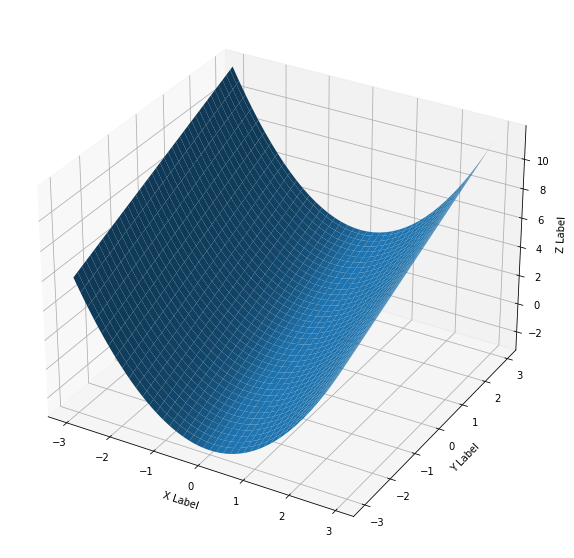

In [11]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  
# Axes3D import has side effects, it enables using projection='3d' in add_subplot
import matplotlib.pyplot as plt
import random

def fun(x, y):
    return x**2 + y

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(-3.0, 3.0, 0.05)
X, Y = np.meshgrid(x, y)
zs = np.array(fun(np.ravel(X), np.ravel(Y)))
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()